In [1]:
%matplotlib notebook

# LQG kontrola invertiranog njihala.
# LQG = Kalmanov filtar kao promatrač + LQR kontrola
import math;
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.linalg as sla;
import control.matlab as con;
from matplotlib.animation import FuncAnimation;

con.use_numpy_matrix(flag=False, warn=True)

In [2]:
# Fizikalne veličine.
M = 0.5;
m = 0.2;
b = 0.1;
I = 0.006;
g = 9.8;
l = 0.3;

# Pomoćna konstanta.
DD = I*(M+m)+M*m*l*l;

In [3]:
# Definicija LTI sustava.
# Sada pretpostavljamo realniju situaciju:
# ne možemo mjeriti sva stanja sustava, nego je izlaz samo (npr.) pozicija x(1) i kut x(3).
# Izlaz iz sustava je i samo u (kojeg ćemo proslijediti promatraču).
A = np.array( [
    [0, 1, 0, 0],
    [0, -b*(I+m*l*l)/DD, m*m*g*l*l/DD, 0],
    [0, 0, 0, 1],
    [0, -b*m*l/DD, (M+m)*m*g*l/DD, 0] ] );
B = np.array( [
    [0],
    [(I+m*l*l)/DD],
    [0],
    [m*l/DD] ] );
C = np.array( [
    [1, 0, 0, 0],
    [0, 0, 1, 0] ] );
D = np.array( [
    [0],
    [0] ] );
sys_G = con.ss( A, B, C, D );

# Promatrač treba dobiti i ulaz u, pa stvaramo još jedan fiktivni izlaz iz sustava
# tako da ga možemo spojiti sa promatračem na kraju.
CC = np.array( [
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0] ] );
DD = np.array( [
    [0],
    [0],
    [1] ] );
sys_Gu = con.ss( A, B, CC, DD );

In [4]:
# Da bismo napravili LQR trebamo stanja x koja nam nisu dostupna.

# Aproksimaciju stanja na temelju izlaza y radimo pomoću promatrača.

# Napravimo prvo tu aproksimaciju pomoću Luenbergerovog promatrača.
# Za to nam treba matrica L takva da je A+LC Hurwitzova.
# Recimo, nađimo L tako da A+LC ima polove u (-0.4, -0.5, -0.6, -0.7).
# (Postoje i bolji izbori -- no kako ih odrediti???)
# (Kalmanov filtar će zapravo dati jedan bolji izbor.)
L = con.place( A.T, C.T, [-0.4, -0.5, -0.6, -0.7 ] );
L = L.T;
print( sla.eigvals( A - L @ C ) );

# Promatrač ima ulaze y i u, a izlaz mu je aproksimacija stanja x_p:
# x_p' = A*x_p + B*u + L(y-C*x_p)
# x_p' = (A-L*C)*x_p + L*y + B*u
# (vidi Luenbergerov promatrač; ovdje koristimo D=0)
A_P = A - L@C;
B_P = np.hstack( (L, B) );
C_P = np.eye( 4 );
D_P = np.zeros( (4, 3) );

sys_P = con.ss( A_P, B_P, C_P, D_P );

# I sada napravimo LQR kontrolu: K odaberemo na temelju
# originalnog sustava, kao u primjeru 09 - LQR pendulum.
Q = np.diag( [100, 1, 30, 1], 0 );
R = 1;
[K, X, Lam] = con.lqr( sys_G, Q, R );

A_K = np.zeros( (0, 0) );
B_K = np.zeros( (1, 0) );
C_K = np.zeros( (0, 4) );
D_K = K;
sys_K = con.ss( A_K, B_K, C_K, D_K );

# Konstruirajmo sustav nastao spajanjem P i K.
# (Ovaj sustav nećemo koristiti u donjoj simulaciji jer ne daje
# mogućnost dodavanja vanjskog mjerenja y kao ni šuma.)
sys_PK = con.series( sys_P, sys_K );

# Napravimo spoj u feedback petlju sys_PK sa sys_Gu, čisto za provjeru polova.
# Uoči: polovi su unija svoj. vr. od A-LC i A-BK (vidi 09 - LQR pendulum).
sys_GuPK = con.feedback( sys_Gu, sys_PK );
print( con.pole( sys_GuPK ) );

[-0.4+0.j -0.7+0.j -0.6+0.j -0.5+0.j]
[-7.13370138+0.j         -5.5180531 +0.j         -2.62952154+2.09806293j
 -2.62952154-2.09806293j -0.4       +0.j         -0.7       +0.j
 -0.6       +0.j         -0.5       +0.j        ]


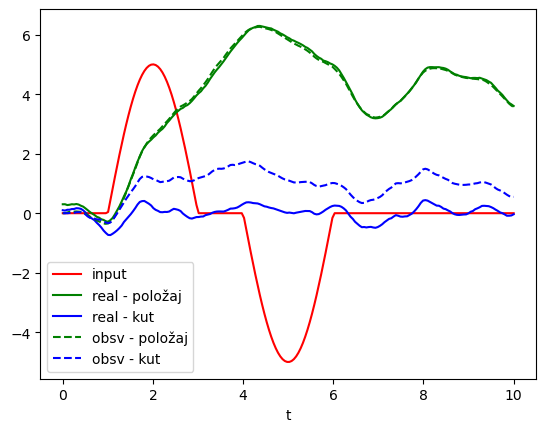

In [5]:
# Napravimo simulaciju sa sys_GuPK, uz input koji simulira kao da je netko 
# malo gurnuo kolica u nekom smjeru.

# Želimo vidjeti što se događa kada u sustavu postoji šum.
# Da bismo dodali šum, kontinuirani sustav ćemo simulirati diskretnim.

# Vremenski interval i input (uoči: povećeli smo t_intervals radi numeričke točnosti)
t_max = 10; t_intervals = 200; dt = t_max / t_intervals;
t = np.linspace( 0, t_max, t_intervals );

# Input.
def uu( t ):
    if( t < 1 ):
        return 0;
    elif( t < 3 ):
        return 5*math.sin( (t-1)*math.pi/2 );
    elif( t < 4 ):
        return 0;
    elif( t < 6 ):
        return -5*math.sin( (t-4)*math.pi/2 );
    else:
        return 0;

u = list( map( uu, t ) );

# Šum u modelu: random 4x1 vektor u svakom trenutku.
# (Uoči: 0.2 je poprilično velik šum, naročito za kut)
# Vektor w će imati Sigma_w = (0.2)^2*I = 0.04 I.
sqrt_sigma_w = 0.2; 
w = sqrt_sigma_w * np.random.randn( 4, t_intervals ); # Sada je E[ww^T] = 0.04*I.

# Šum u mjerenju: random 2x1 vektor.
# (Uoči: 0.1 je poprilično velik šum, naročito za kut.)
# Vektor v će imati Sigma_v = (0.1)^2*I = 0.01 I.
sqrt_sigma_v = 0.1;
v = sqrt_sigma_v * np.random.randn( 2, t_intervals ); # Sada je E[vv^T] = 0.01*I.

# Početno stanje (uoči: i ono je nepoznato promatraču/kontroleru)
x0 = np.array( [0.3, 0, 0.1, 0] );

# Simulacija.
x_real = np.zeros( (4, t_intervals) ); # Stvarno stanje.
x_obsv = np.zeros( (4, t_intervals) ); # Ono što vidi promatrač.
y = np.zeros( (2, t_intervals) ); # Mjerenja (simuliramo).

x_real[:, 0] = x0;
x_obsv[:, 0] = np.array( [0, 0, 0, 0] ); # Ne zna stvarno stanje.
u_K = np.array( [0] ); # Izlaz iz kontrolera u trenutku 0.

for k in range(0, t_intervals-1):
    # Ulaz u trenutku dt*k je zbroj vanjske sile i onog što daje kontroler.
    ulaz = np.array( [u[k]] ) - u_K;
    
    # Što se stvarno dogodi:
    x_real[:, k+1] = x_real[:, k] + dt*( A @ x_real[:, k] + B @ ulaz + w[:, k] );
    
    # Simuliramo mjerenje:
    y[:, k+1] = C @ x_real[:, k+1] + D @ ulaz + v[:, k];

    # Sada to prosljeđujemo promatraču:
    x_obsv[:, k+1] = x_obsv[:, k] + dt*( (A - L @ C) @ x_obsv[:, k] + B @ ulaz + L @ y[:, k] );
    
    # LQR kontrolor generira kontrolu na temelju x_obsv.
    u_K = K @ x_obsv[:, k+1];
    

# Crtamo poziciju i kut, stvarnu i onu koju je dao promatrač.
%matplotlib inline

x_real = x_real.T;
x_obsv = x_obsv.T;

f = plt.figure;
plt.plot( t, u, 'r-', label='input' );
plt.plot( t, x_real[:, 0], 'g-', label='real - položaj' );
plt.plot( t, x_real[:, 2], 'b-', label='real - kut' );
plt.plot( t, x_obsv[:, 0], 'g--', label='obsv - položaj' );
plt.plot( t, x_obsv[:, 2], 'b--', label='obsv - kut' );
plt.xlabel( 't' );
plt.legend();
plt.show();

In [6]:
# Sad ćemo napraviti LQG kontrolu.
# Jedina razlika je u promatraču: sada ga računamo pomoću Kalmanovog filtera.
# Kontroler ostaje potpuno isti (u_K = K*x_KF, K je kao gore).

# Odredimo matricu za Kalmanov gain.
Sigma_w = sqrt_sigma_w*sqrt_sigma_w * np.eye(4); # Sigma_w = (0.4)^2 * I4
Sigma_v = sqrt_sigma_v*sqrt_sigma_v * np.eye(2); # Sigma_v = (0.2)^2 * I2
F = np.eye(4);

# Riješimo (algebarsku) Riccatijevu jednadžbu da odredimo Sigma.
Sigma = con.care( A.T, C.T, F @ Sigma_w @ F.T, Sigma_v )[0];

# Kalmanov "gain".
KG = Sigma @ C.T @ sla.inv(Sigma_v); # Trebalo bi izbjeći inv...

# Provjera:
print( sla.norm( A @ Sigma + Sigma @ A.T - Sigma @ C.T @ sla.inv(Sigma_v) @ C @ Sigma + F @ Sigma_w @ F.T, 'fro' ) );

# Aproksimacija stanja je dana sa
# x_KF'(t) = A*x_KF(t) + B*u(t) + KG*(y(t) - y_KF(t))
# y_KF(t) = C*x_KF(t) + D*u(t)

# I Kalmanov filtar možemo zapisati kao sustav s ulazima y i u:
# Uoči: y_KF smo uvrstili u jednadžbu za x_KF'(t).
# Output su ponovno stanja x_KF koja ćemo proslijediti LQR kontroleru.
A_KF = A - KG @ C;
B_KF = np.hstack( ( KG, B - KG @ D ) );
C_KF = np.eye( 4 );
D_KF = np.zeros( (4, 3) );

sys_KF = con.ss( A_KF, B_KF, C_KF, D_KF );

# Konstruirajmo sustav nastao spajanjem KF i K.
# (Ovaj sustav nećemo koristiti u donjoj simulaciji jer ne daje
# mogućnost dodavanja vanjskog mjerenja y kao ni šuma.)
sys_KFK = con.series( sys_KF, sys_K );

sys_GuKFK = con.feedback( sys_Gu, sys_KFK );
print( 'Polovi u feedback petlji: ', con.pole( sys_GuKFK ) );

1.6619964747039444e-14
Polovi u feedback petlji:  [-2.62952154+2.09806293j -2.62952154-2.09806293j -1.42465939+0.0285143j
 -1.42465939-0.0285143j  -7.13370138+0.j         -6.66250666+0.j
 -4.68508447+0.j         -5.5180531 +0.j        ]


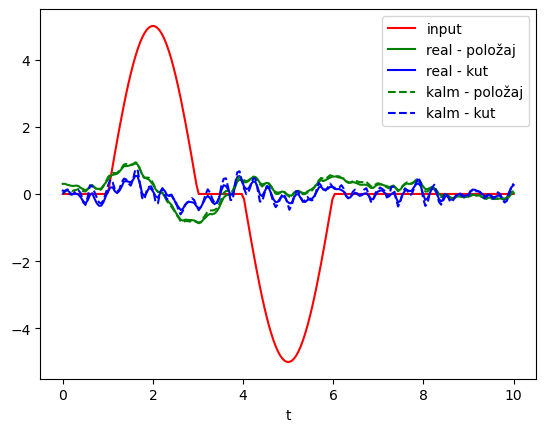

In [7]:
# Napravimo sada simulaciju sa sys_GuKFK, uz input koji simulira kao da je netko 
# malo gurnuo kolica u nekom smjeru i uz šum kao u gornjem primjeru.

# Simulacija.
x_rea2 = np.zeros( (4, t_intervals) ); # Stvarno stanje.
x_kalm = np.zeros( (4, t_intervals) ); # Ono što vidi promatrač - Kalmanov filtar.
y_kalm = np.zeros( (2, t_intervals) ); # Aproksimacije za output koje radi KF.
y = np.zeros( (2, t_intervals) ); # Mjerenja (simuliramo).

x_rea2[:, 0] = x0;
x_kalm[:, 0] = np.array( [0, 0, 0, 0] ); # Ne zna stvarno stanje.
u_K = np.array( [0] ); # Izlaz iz kontrolera u trenutku 0.

for k in range(0, t_intervals-1):
    # Ulaz u trenutku dt*k je zbroj vanjske sile i onog što daje kontroler.
    ulaz = u[k] - u_K;
    
    # Što se stvarno dogodi:
    x_rea2[:, k+1] = x_rea2[:, k] + dt*( A @ x_rea2[:, k] + B @ ulaz + w[:, k] );
    
    # Simuliramo mjerenje:
    y[:, k+1] = C @ x_rea2[:, k+1] + D @ ulaz + v[:, k];

    # Sada to prosljeđujemo Kalmanovom filteru:
    x_kalm[:, k+1] = x_kalm[:, k] + dt*( A @ x_kalm[:, k] + B @ ulaz + KG @ (y[:, k+1]-y_kalm[:, k]) );
    y_kalm[:, k+1] = C @ x_kalm[:, k+1] + D @ ulaz;
    
    # LQR kontroler generira kontrolu na temelju x_kalm.
    u_K = K @ x_kalm[:, k+1];
    

# Crtamo poziciju i kut, stvarnu i onu koju je dao Kalmanov filtar.
%matplotlib inline

x_rea2 = x_rea2.T;
x_kalm = x_kalm.T;

f = plt.figure;
plt.plot( t, u, 'r-', label='input' );
plt.plot( t, x_rea2[:, 0], 'g-', label='real - položaj' );
plt.plot( t, x_rea2[:, 2], 'b-', label='real - kut' );
plt.plot( t, x_kalm[:, 0], 'g--', label='kalm - položaj' );
plt.plot( t, x_kalm[:, 2], 'b--', label='kalm - kut' );
plt.xlabel( 't' );
plt.legend();
plt.show();

In [8]:
# Sljedeće tri linije omogućavaju crtanje animacija u Jupyter notebooku.
%matplotlib inline

from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

# Napravimo i animacije za oba sustava, na istoj slici.
# Uoči da skala na x i na y osi nije ista i da se zapravo njihala "jače" ljuljaju no što se čini na slici.
# Napravimo sliku koja je široka "16", a visoka "2" da malo kompenziramo razliku skala.
fig = plt.figure( figsize=(16, 2) ); 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-8, 8), ylim=(-l*1.1, l*1.1))
ax.grid()

# Svaki dio njihala će biti jedan plot unutar figure. 
# Uočite da je ova inicijalizacija prazna, tj. polja x koord. i y koord. su oba [] i zapravo se ništa ne crta.
pendulum1, = ax.plot([], [], 'b-', lw=2)           # "Štap" prvog njihala.
pendulum1_top, = ax.plot([], [], 'ko', lw=2)       # "Kugla" na vrhu prvog njihala.
pendulum1_base, = ax.plot([], [], 'b-', lw=2)      # "Kolica" prvog njihala.
pendulum1_vert, = ax.plot([], [], 'k--', lw=0.5)   # Os okomice prvog njihala.

pendulum2, = ax.plot([], [], 'g-', lw=2)           # "Štap" drugog njihala.
pendulum2_top, = ax.plot([], [], 'ko', lw=2)       # "Kugla" na vrhu drugog njihala.
pendulum2_base, = ax.plot([], [], 'g-', lw=2)      # "Kolica" drugog njihala.
pendulum2_vert, = ax.plot([], [], 'k--', lw=0.5)   # Os okomice drugog njihala.

input_vector, = ax.plot([], [], 'r-', lw=2)        # Ovdje ćemo crtati smjer sile koja djeluje na njihalo.

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes) # Ispisivat ćemo vrijeme na koord. (0.05, 0.9).

def update(i):
    # Crtamo sliku u trenutku i.
    # Baza prvog njihala ("kolica").
    x1 = x_real[i, 0]; # Kolica se nalaze na koordinatama (x1, y1).
    y1 = 0;
    
    # "Kugla" njihala (tamo gdje je masa) je na koordinatama (x2, y2).
    x2 = x1 + l*math.sin(x_real[i, 2]);
    y2 = y1 + l*math.cos(x_real[i, 2]);
    
    # Sad nacrtamo prvo njihalo, tj. promijenimo x i y koordinate koje se prikazuju na odgovarajućem plotu.
    # Uočite da će biti nacrtan niz linija koji povezuje redom koordinate navedene u poljima.
    # Tj. plot.set_data([x1, x2, x3], [y1, y2, y3]) crta linije (x1, y1)--(x2, y2)--(x3, y3).
    pendulum1.set_data( [x1, x2], [y1, y2] );
    pendulum1_top.set_data( [x2], [y2] );
    pendulum1_base.set_data( [x1-1, x1-1, x1+1, x1+1, x1-1], [y1, y1-0.05, y1-0.05, y1, y1] );
    pendulum1_vert.set_data( [x1, x1], [y1, y1+0.3] );
    
    # Baza drugog njihala ("kolica").
    x1 = x_rea2[i, 0]; # Kolica se nalaze na koordinatama (x1, y1).
    y1 = 0;
    
    # "Kugla" njihala (tamo gdje je masa) je na koordinatama (x2, y2).
    x2 = x1 + l*math.sin(x_rea2[i, 2]);
    y2 = y1 + l*math.cos(x_rea2[i, 2]);
    
    # Sad nacrtamo drugo njihalo, na isti način kao prvo.
    pendulum2.set_data( [x1, x2], [y1, y2] );
    pendulum2_top.set_data( [x2], [y2] );
    pendulum2_base.set_data( [x1-1, x1-1, x1+1, x1+1, x1-1], [y1, y1-0.05, y1-0.05, y1, y1] );
    pendulum2_vert.set_data( [x1, x1], [y1, y1+0.3] );

    # Nacrtaj iznos sile u trenutku i kao vodoravnu liniju koja spaja točke 0 i u[i].
    input_vector.set_data( [0, u[i]], [-l, -l] );
    
    # Napiši trenutno vrijeme u gornji lijevi kut.
    time_text.set_text( time_template % (i*dt) );
    

# Generira "animaciju" na slici fig tako da za svaki od frameova i iz [0, 1, ..., t_intervals-1] pozove funkciju update(i)
ani = FuncAnimation(fig, update, frames=list( range( 0, t_intervals ) ) );

plt.close(); # Zatvori inicijalni prazni plot.
ani      # Prikaži animaciju

# Plavo = x_real (za Luenbergerov promatrač).
# Zeleno = x_rea2 (za Kalmanov filtar).

#### 